Многие люди используют статистическую проверку гипотез, даже не подозревая об этом. Понятно, что когда кто-то проводит A / B-тест, формально проверяется статистическая гипотеза. Есть достаточно много грабель, на которые можно наступить при проверке гипотез, некоторые из них очевидны (или будут очевидны - проведите достаточно тестов, и вы что-нибудь найдете!), Некоторые из них более тонкие/менее понятные. Один из наиболее хитрых моментов заключается в том, что вы не можете преждевременно прекратить эксперимент.

Когда вы начали сбор данных и вдруг на второй день увидели, что p-value стало меньше чем $\alpha$, сразу хочется кричать: "Ура, эта новая кнопка работает! Люди подписываются в рекордном количестве!". На самом деле это чепуха. Попробуем разобраться почему.

Хотя использование A / B-тестирования такое "новомодное", само по себе тестирование гипотез существует очень давно. Как минимум, его постоянно используют (в том числе неправильно) в медицинских исследованиях и в области физики высоких энергий. Это означает, что значительное количество ловушек уже было обнаружено ранее, и вам при проведении A / B нет необходимости открывать их заново. Вот недавний пример от AirBnB: [Эксперименты в AirBnB](http://nerds.airbnb.com/experiments-at-airbnb/). Аналитики там пытаются останавливать эксперименты пораньше, тут кратко описано, какую методологию они для этого используют. В сообщении недостаточно информации, чтобы показать, что их метод работает, но давайте предположим, что это так. Одна вещь, о которой не говорится, - это то, как ранняя остановка влияет на мощность вашего теста.

In [2]:
%matplotlib inline

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import random

random.seed(12345)
np.random.seed(5345436)

Первое, что нам понадобится - выборка. Пусть в эксперименте вы измеряете коэффициент конверсии на своем веб-сайте. Средняя конверсия - 6%. Группа А будет иметь средний коэффициент конверсии 6%, используя параметр `difference`, мы контролируем, насколько большой должна быть разница между двумя выборками. Это позволяет нам генерировать набор наблюдений, в которых истинная разница равна нулю или любому другому значению, которое мы хотели бы исследовать. Мы также можем установить размер выборки (количество наблюдений) `N`.

Будем использовать t-критерий Стьюдента для расчета p-значения для каждого эксперимента. В этом примере мы хотим знать, улучшили ли изменения на нашем веб-сайте коэффициент конверсии или нет. p-значение - это вероятность того, что мы при отсутствии разницы между выборками получим такое же или еще более экстремальное значение статистики, как в эксперименте. В этом случае вы (как будто бы) можете рассчитать p-значение, используя [t-test Стьюдента](http://en.wikipedia.org/wiki/Student%27s_t-test).

In [3]:
def two_samples(difference, N=6500, delta_variance=0.):
    As = np.random.normal(6., size=N)
    Bs = np.random.normal(6. + difference, scale=1+delta_variance, size=N)
    return As, Bs

def one_sided_ttest(A, B, equal_var=True):
    t,p = stats.ttest_ind(A, B, equal_var=equal_var)
    # t-тест, реализованный в scipy, двусторонний, но нас интересует
    # односторонняя гипотеза (поделим пополам)
    if t < 0:
        p /= 2.
    else:
        p = 1- p/2.

    return p

Пора проводить эксперимент. Предположим, что всего вы собираете по 100 наблюдений в каждой группе. Чтобы увидеть, что происходит с p-значением по мере сбора данных, мы построим его график после получения каждого нового наблюдения в каждой группе.

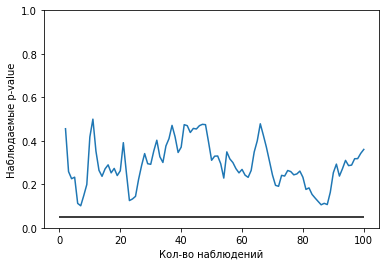

In [4]:
# Разницы между группами нет
As, Bs = two_samples(0., N=100)
p_vals = []
for n in range(len(As)-1):
    n += 2
    p_vals.append(one_sided_ttest(As[:n], Bs[:n]))

a = plt.axes()
a.plot(np.arange(len(As)-1)+2, p_vals)
a.set_ylabel("Наблюдаемые p-value")
a.set_xlabel("Кол-во наблюдений")
a.set_ylim([0., 1.])
a.hlines(0.05, 0, 100)

Как видите, в ходе эксперимента оно немного меняется. Хотя в данном конкретном случае оно ни разу не стало меньше 0,05, вам не нужно слишком часто перезапускать эту ячейку, чтобы найти ту, где она есть.

Если бы вам пришлось провести большое количество экспериментов, в которых вы показываете одну и ту же веб-страницу обеим группам и наносите на график значение p, которое вы видите, вы бы получили что-то такое:

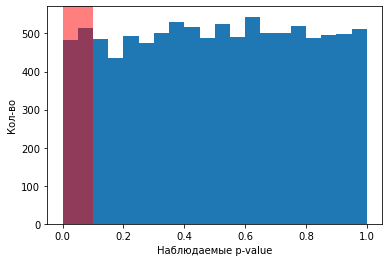

In [5]:
def repeat_experiment(repeats=10000, diff=0.):
    p_values = []
    for i in range(repeats):
        A,B = two_samples(diff, N=100)
        p = one_sided_ttest(A,B)
        p_values.append(p)
    
    plt.hist(p_values, range=(0,1.), bins=20)
    plt.axvspan(0., 0.1, facecolor="red", alpha=0.5)
    plt.xlabel("Наблюдаемые p-value")
    plt.ylabel("Кол-во")
    
repeat_experiment()

Как видите, ~ 10% наблюдаемых p-значений попадают в красную область. Точно так же 5% ваших экспериментов дадут вам p-значение менее 0,05. И все это несмотря на отсутствие разницы!

Это подводит нас к тому, что именно делает для вас процедура проверки гипотез. Принимая решение о том, что победила группа В, если мы видим p-значение меньше 0,05, вы говорите: в долгосрочной перспективе, после многократных повторений этого эксперимента, я дам "ложноположительный" результат не более чем в 5% случаев (ошибки первого рода).

Заметьте, тут нет никакой информации о том, насколько вероятно, что вы действительно что-то нашли. Тут не говорится, правильный ли выбор вы сделали в конкретном случае. Только то, что в конечном итоге, при многократном повторении этого эксперимента вы будете ошибаться в 5% случаев.

Итак, при чем тут ранняя остановка?

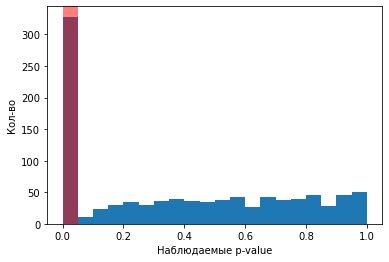

In [6]:
def repeat_early_stop_experiment(repeats=1000, diff=0.):
    p_values = []
    for i in range(repeats):
        A,B = two_samples(diff, N=100)

        for n in range(len(A)-1):
            n += 2
            p = one_sided_ttest(A[:n], B[:n])
            if p < 0.05:
                break
            
        p_values.append(p)
    
    plt.hist(p_values, range=(0,1.), bins=20)
    plt.axvspan(0., 0.05, facecolor="red", alpha=0.5)
    plt.xlabel("Наблюдаемые p-value")
    plt.ylabel("Кол-во")
    return p_values
    
p_values = repeat_early_stop_experiment()

In [11]:
sum(np.array(p_values)<0.05)

317

Вы видите маленькое p-value и останавливаете эксперимент, говорите, что победила группа В и идете праздновать. 

А на самом деле вы видите p-value < 0,05 во много раз чаще, чем 5% всех экспериментов (1000 * 0,05 = 50). В конечном итоге вы будете ошибаться намного чаще чем в 5% случаев.

Что такое мощность? Мощность теста - вероятность того, что вы увидите изменение там, где оно есть (1 - FNR). Очевидно это должно зависеть от того, насколько велика разница между группами А и В и того, сколько наблюдений вы сделаете. Чем больше улучшение, тем легче его обнаружить. Если B увеличит ваш коэффициент конверсии с 6 до 20%, вы заметите это намного легче, чем если бы он изменился с 6 до 7%.

Давайте посмотрим, что произойдет, если вы будете останавливать эксперименты раньше времени.

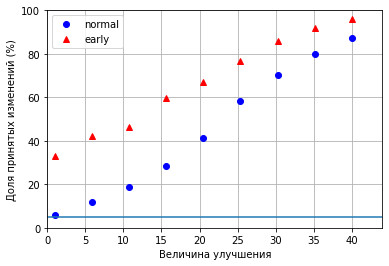

In [12]:
def keep_or_not(improvement, threshold=0.05, N=100, repeats=1000, early_stop=False):
    keep = 0
    for i in range(repeats):
        A,B = two_samples(improvement, N=N)

        if early_stop:
            for n in range(len(A)-1):
                n += 2
                p = one_sided_ttest(A[:n], B[:n])
                if p < 0.05:
                    break

        else:
            p = one_sided_ttest(A, B)
            
        if p <= threshold:
            keep += 1
            
    return float(keep)/repeats

def power_plot(improvements, normal_keeps, early_keeps):
    plt.plot(improvements, normal_keeps, "bo", label="normal")
    plt.plot(improvements, early_keeps, "r^", label="early")
    
    plt.legend(loc="best")
    plt.ylim((0, 100))
    plt.xlim((0, improvements[-1]*1.1))
    plt.grid()
    plt.xlabel("Величина улучшения")
    plt.ylabel("Доля принятых изменений (%)")
    plt.axhline(5)

improvements = np.linspace(1., 40, 9)

keeps = []
early_keeps = []
for improvement in improvements:
    keeps.append(keep_or_not(improvement/100.)*100)
    early_keeps.append(keep_or_not(improvement/100., early_stop=True)*100)

power_plot(improvements, keeps, early_keeps)

Отлично! Рано останавливая эксперимент, вы чаще меняете свою веб-страницу на альтернативную, когда действительно есть эффект! Если улучшение составляет от 6% до 7%, вероятность того, что вы правильно измените, почти в шесть раз выше.

Вам кажется, что стало лучше. Но нет :( Причина в том, что мы не учитываем количество ложных срабатываний. Как мы видели ранее, если вы остановитесь раньше, вы неправильно меняете свой дизайн сайта чаще, чем в 5% случаев. Мощность теста также зависит от того, как часто вы готовы ошибаться. Если у вас нет проблем с тем, чтобы все время ошибаться, то лучшая стратегия - всегда переключаться. Вы будете правильно переключаться в 100% случаев.

Каков же на самом деле процент ложных срабатываний стратегии ранней остановки?

In [16]:
def false_positives(repeats=1000, early_stop=False, threshold=0.05):
    switches = 0
    for i in range(repeats):
        A,B = two_samples(0., N=100)

        if early_stop:
            for n in range(len(A)-1):
                n += 2
                p = one_sided_ttest(A[:n], B[:n])
                if p < threshold:
                    break
                    
        else:
            p = one_sided_ttest(A, B)
        
        if p < threshold:
            switches += 1

    return float(switches)/repeats

print("Обычный тест:", false_positives())
print("Ранняя остановка:", false_positives(early_stop=True))

Обычный тест: 0.047
Ранняя остановка: 0.295


При принятии решения после того, как были собраны все наблюдения, частота ложных срабатываний действительно близка к 5%, как и обещает процедура проверки гипотез. Для метода раннего останова вы получаете около 30% ложных срабатываний!

Насколько ниже мы должны сделать порог p-значения с помощью стратегии раннего останова, чтобы иметь такую же частоту ложных срабатываний в 5%?

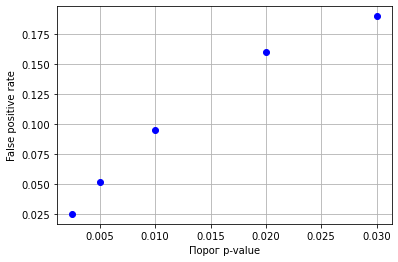

In [17]:
thresholds = (0.0025, 0.005, 0.01, 0.02, 0.03)
fp_rates = [false_positives(threshold=p, early_stop=True) for p in thresholds]

plt.plot(thresholds, fp_rates, "bo")
plt.xlabel("Порог p-value")
plt.ylabel("False positive rate")
plt.grid()

Порог, используемый для ранней остановки эксперимента, должен быть намного ниже 0,05, чтобы достичь того же фактического количества ложных срабатываний. Теперь мы можем повторно запустить наше сравнение мощности двух тестов (нормального и нормального с ранней остановкой). Ниже нарисованы графики мощности обоих тестов для 5% ложноположительных результатов. 

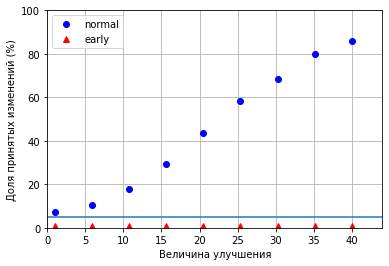

In [18]:
improvements = np.linspace(1., 40, 9)

keeps = []
early_keeps = []
for improvement in improvements:
    keeps.append(keep_or_not(improvement/100.)*100)
    early_keeps.append(keep_or_not(improvement/100.,
                                   early_stop=True,
                                   threshold=0.005)*100)

power_plot(improvements, keeps, early_keeps)

Как-то так! Вы почти никогда не будете принимать решение в пользу новой веб-страницы. Останавливая тест раньше и удерживая на том же уровне количество ложных срабатываний, вы делаете свой тест оооооочень малочувствительным.

На самом деле, чаще всего раннюю остановку сделать хочется, чтоб "быстрее раскатить результаты" и "заработать побольше". Тут есть пара методов, о которых мы попозже поговорим, один из них – [Последовательный анализ](https://en.wikipedia.org/wiki/Sequential_analysis), а второй – [Многорукие бандиты](https://en.wikipedia.org/wiki/Multi-armed_bandit)